In [182]:
#!pip install python-louvain (https://github.com/taynaud/python-louvain/blob/master/README.rst)
# run in Python 3.10.7

For amazon, an item can belong to multiple or none of the community

In [183]:
import networkx as nx
import time

import community.community_louvain as community_louvain
import leidenalg as la
import igraph as ig
from collections import defaultdict

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Data Visualization

### True Graph

In [184]:
# Transform train samples into a graph
G = nx.Graph()

# Read the .txt file
with open('amazon/com-amazon.ungraph.txt', 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(int(node1), int(node2))

# Display the graph info
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))
print("Graph is connected: ", nx.is_connected(G), "\n")

The number of nodes: 334863
The number of edges: 925872
Graph is connected:  True 



In [208]:
true_labels = defaultdict(list)
# Read the .txt file
with open('amazon/com-amazon.all.dedup.cmty.txt', 'r') as file:
    i = 0
    for line in file:
        L_nodes = line.strip().split()
        for node in L_nodes:
                true_labels[int(node)].append(i)
        i+=1
print(f"Number of communities: {i}")

Number of communities: 75149


In [209]:
# To see if every node is attributed to one and only one community

assert len(true_labels.keys()) == G.number_of_nodes()

AssertionError: 

In [210]:
for node in G.nodes():
    if node not in true_labels.keys():
        true_labels[node] = [i+1]
        
assert len(true_labels.keys()) == G.number_of_nodes()

<u>Remark</u>: We encountered an error because some nodes are not assigned to any community. To address this, we created a new community that includes all nodes without a community assignment.

### Useful functions

In [188]:
def scores(dict_labels: dict, algo_name: str):

    true_labels_list = [true_labels[node] for node in G.nodes()]
    dict_labels_list = [dict_labels[node] for node in G.nodes()]

    ari_score = adjusted_rand_score(true_labels_list, dict_labels_list)
    print(f"Adjusted Rand Index (ARI) for {algo_name}: {ari_score:.4f}")

    nmi_score = normalized_mutual_info_score(true_labels_list, dict_labels_list)
    print(f"Normalized Mutual Info (NMI) for {algo_name}: {nmi_score:.4f}")

    s = 0
    for node in G.nodes():
        if dict_labels[node] == true_labels[node]:
            s += 1
    print(f"Accuracy for {algo_name}: {s/len(G.nodes):.4f}")

## Louvain

In [ ]:
start = time.time()
# Apply Louvain algorithm
louvain_partition = community_louvain.best_partition(G)

# Create a mapping from Louvain community to true labels
community_to_true = defaultdict(list)
for node, louvain_com in louvain_partition.items():
    community_to_true[louvain_com].append(true_labels[node])

# Assign the most common true label to each leiden community
louvain_with_true_label = {com: max(set(labels), key=labels.count) for com, labels in community_to_true.items()}

# Assign each node the corresponding true label
louvain_labels = {node: louvain_with_true_label[louvain_partition[node]] for node in louvain_partition}
duration = time.time() - start

louvain_labels

{1: 51893,
 88160: 51893,
 118052: 51893,
 161555: 51893,
 244916: 51893,
 346495: 51893,
 444232: 51893,
 447165: 51893,
 500600: 51893,
 2: 64718,
 27133: 64718,
 62291: 64718,
 170507: 64718,
 299250: 64718,
 326776: 64718,
 331042: 64718,
 411179: 64718,
 451149: 64718,
 454888: 64718,
 4: 51661,
 16050: 51661,
 286286: 51661,
 310803: 51661,
 320519: 51661,
 408108: 51661,
 448284: 51661,
 5: 48565,
 173362: 48565,
 305321: 48565,
 407216: 48565,
 489756: 48565,
 6: 47061,
 162248: 47061,
 298989: 47061,
 398542: 47061,
 495077: 47061,
 7: 64601,
 30028: 64601,
 47672: 64601,
 355935: 64601,
 8: 27465,
 10758: 27465,
 55461: 27465,
 60605: 27465,
 148586: 27465,
 184847: 27465,
 242156: 63016,
 445607: 27465,
 453513: 27465,
 10: 63016,
 80558: 63016,
 192929: 63016,
 266485: 63016,
 500235: 63016,
 504757: 63016,
 11: 60658,
 57761: 60658,
 107436: 60658,
 400957: 60658,
 512424: 60658,
 12: 60658,
 386032: 60658,
 15: 69079,
 67084: 69079,
 85444: 69079,
 252980: 69079,
 422732:

In [ ]:
algo_name = "Louvain"

scores(louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

Adjusted Rand Index (ARI) for Louvain: 0.2633
Normalized Mutual Info (NMI) for Louvain: 0.4966
Accuracy for Louvain: 0.2924
Time for Louvain: 54.0259 s


## Leiden

In [ ]:
# The implemented Leiden needs igraph format
G_ig = ig.Graph.from_networkx(G)

In [ ]:
start = time.time()
partition = la.find_partition(G_ig, la.ModularityVertexPartition)

# Print community assignments
leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

# Create a mapping from Leiden community to true labels
community_to_true = defaultdict(list)
for node, leiden_com in leiden_partition.items():
    community_to_true[leiden_com].append(true_labels[node])

# Assign the most common true label to each Louvain community
leiden_with_true_label = {com: max(set(labels), key=labels.count) for com, labels in community_to_true.items()}

# Assign each node the corresponding true label
leiden_labels = {node: leiden_with_true_label[leiden_partition[node]] for node in leiden_partition}
duration = time.time() - start

leiden_labels

{1: 73852,
 88160: 73852,
 118052: 73852,
 161555: 73852,
 244916: 73852,
 346495: 73852,
 444232: 73852,
 447165: 73852,
 500600: 73852,
 2: 64718,
 27133: 64718,
 62291: 64718,
 170507: 64718,
 299250: 64718,
 326776: 64718,
 331042: 64718,
 411179: 64718,
 451149: 64718,
 454888: 64718,
 4: 51661,
 16050: 51661,
 286286: 51661,
 310803: 51661,
 320519: 51661,
 408108: 51661,
 448284: 51661,
 5: 48565,
 173362: 48565,
 305321: 48565,
 407216: 48565,
 489756: 48565,
 6: 47061,
 162248: 47061,
 298989: 47061,
 398542: 47061,
 495077: 47061,
 7: 64601,
 30028: 64601,
 47672: 64601,
 355935: 64601,
 8: 69079,
 10758: 69079,
 55461: 69079,
 60605: 69079,
 148586: 69079,
 184847: 69079,
 242156: 75150,
 445607: 69079,
 453513: 69079,
 10: 63016,
 80558: 63016,
 192929: 63016,
 266485: 63016,
 500235: 63016,
 504757: 63016,
 11: 60658,
 57761: 60658,
 107436: 60658,
 400957: 60658,
 512424: 60658,
 12: 40133,
 386032: 40133,
 15: 69079,
 67084: 69079,
 85444: 69079,
 252980: 69079,
 422732:

In [ ]:
algo_name = "Leiden"

scores(leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

Adjusted Rand Index (ARI) for Leiden: 0.2806
Normalized Mutual Info (NMI) for Leiden: 0.5171
Accuracy for Leiden: 0.3044
Time for Leiden: 10.5996 s


# Hierarchical Louvain

In [ ]:
def recursive_louvain(graph, level=0, max_depth=2):
    partition = community_louvain.best_partition(graph)
    communities = {}

    for node, comm_id in partition.items():
        communities.setdefault(comm_id, []).append(node)

    hierarchy = {}
    for comm_id, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        hierarchy[comm_id] = {
            'level': level,
            'nodes': nodes,
            'subcommunities': None
        }

        # Recursive step
        if level + 1 < max_depth and len(nodes) > 3:
            sub_hierarchy = recursive_louvain(subgraph, level + 1, max_depth)
            hierarchy[comm_id]['subcommunities'] = sub_hierarchy

    return hierarchy


def flatten_community_tree(tree, path_prefix=()):
    flat_labels = {}

    for comm_id, info in tree.items():
        path = path_prefix + (comm_id,)
        for node in info['nodes']:
            flat_labels[node] = path

        if info['subcommunities'] is not None:
            sub_flat = flatten_community_tree(info['subcommunities'], path)
            flat_labels.update(sub_flat)

    return flat_labels

In [ ]:
start = time.time()

# Remark: the hierarchical algorithm converges to a stable structure with subcommunities
depth = 5

# Run and flatten
community_tree = recursive_louvain(G, max_depth=depth)
hierar_louvain_partition = flatten_community_tree(community_tree)

# Create a mapping from hierarchical Louvain community to true labels
community_to_true = defaultdict(list)
for node, louvain_com in hierar_louvain_partition.items():
    community_to_true[louvain_com].append(true_labels[node])

# Assign the most common true label to each Louvain community
louvain_with_true_label = {com: max(set(labels), key=labels.count) for com, labels in community_to_true.items()}

# Assign each node the corresponding true label
hierar_louvain_labels = {node: louvain_with_true_label[hierar_louvain_partition[node]] for node in hierar_louvain_partition}
duration = time.time() - start

hierar_louvain_labels

KeyboardInterrupt: 

In [ ]:
algo_name = "Hierarchical Louvain"

scores(hierar_louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

Adjusted Rand Index (ARI) for Hierarchical Louvain: 0.7060
Normalized Mutual Info (NMI) for Hierarchical Louvain: 0.8098
Accuracy for Hierarchical Louvain: 0.7264
Time for Hierarchical Louvain: 168.1784 s


# Hierarchical Leiden

In [189]:
def recursive_leiden(graph, level=0, max_depth=3):
    
    partition = la.find_partition(
        graph,
        la.CPMVertexPartition) # CPMVertexPartition, ModularityVertexPartition
    
    hierarchy = {}

    for i, community in enumerate(partition):
        subgraph = graph.subgraph(community)
        hierarchy[i] = {
            'level': level,
            'nodes': community,
            'subcommunities': None
        }

        if level + 1 < max_depth and len(community) > 3:
            sub_hierarchy = recursive_leiden(subgraph, level + 1, max_depth)
            hierarchy[i]['subcommunities'] = sub_hierarchy

    return hierarchy

def flatten_community_tree(tree, path_prefix=()):
    flat_labels = {}

    for comm_id, info in tree.items():
        path = path_prefix + (comm_id,)
        for node in info['nodes']:
            flat_labels[node] = path

        if info['subcommunities'] is not None:
            sub_flat = flatten_community_tree(info['subcommunities'], path)
            flat_labels.update(sub_flat)

    return flat_labels


In [190]:
# Convert the networkx graph to igraph
G_ig = ig.Graph.from_networkx(G)

In [192]:
s = 0
for node, leiden_com in hierar_leiden_partition.items():
    if node not in true_labels.keys():
        s += 1
print(s)

132559


In [191]:
start = time.time()

# Remark: the hierarchical algorithm converges to a stable structure with subcommunities
depth = 5

# Run and flatten
community_tree = recursive_leiden(G_ig, max_depth=depth)
hierar_leiden_partition = flatten_community_tree(community_tree)

# Create a mapping from hierarchical Leiden community to true labels
community_to_true = defaultdict(list)
for node, leiden_com in hierar_leiden_partition.items():
    community_to_true[leiden_com].append(true_labels[node])

# Assign the most common true label to each Leiden community
leiden_with_true_label = {com: max(set(labels), key=labels.count) for com, labels in community_to_true.items()}

# Assign each node the corresponding true label
hierar_leiden_labels = {node: leiden_with_true_label[hierar_leiden_partition[node]] for node in hierar_leiden_partition}
duration = time.time() - start

print(hierar_leiden_labels)

KeyError: 0

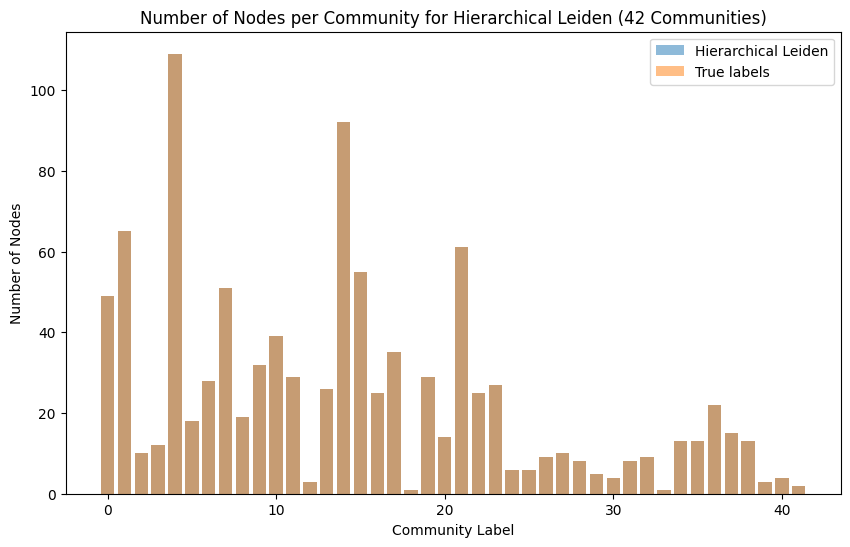

Adjusted Rand Index (ARI) for Hierarchical Leiden: 1.0000
Normalized Mutual Info (NMI) for Hierarchical Leiden: 1.0000
Accuracy for Hierarchical Leiden: 1.0000
Time for Hierarchical Leiden: 0.0374 s


In [ ]:
algo_name = "Hierarchical Leiden"

scores(hierar_leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

<u>Remark</u>: Choosing the `CPMVertexPartition` argument leads to an accuracy of 100%, while `ModularityVertexPartition` leads only to $\approx$ 46%, because our graph contains communities of different sizes, and modularity maximization might not detect the small ones accurately.